In [52]:
import datetime
import time
import numpy as np
import pandas as pd
from packaging import version
from collections import Counter

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [53]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [54]:
def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 

In [55]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [56]:
#Loading Data

In [57]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [58]:
print('train_images:\t{}'.format(x_train.shape))
print('train_labels:\t{}'.format(y_train.shape))
print('test_images:\t{}'.format(x_test.shape))
print('test_labels:\t{}'.format(y_test.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:	(10000, 32, 32, 3)
test_labels:	(10000, 1)


In [59]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [60]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

In [61]:
x_preview, y_preview = get_three_classes(train_images, train_labels)
#x_preview, y_preview = get_three_classes(test_images, test_labels)

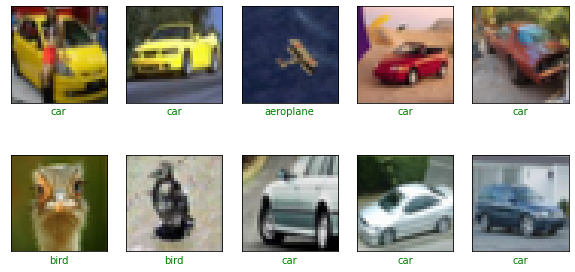

In [62]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [63]:
class_names = ['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']

In [64]:
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train
                                                                              ,y_train
                                                                              ,test_size=.1
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [65]:
print(x_train_split.shape, x_valid_split.shape, x_test.shape)

(45000, 32, 32, 3) (5000, 32, 32, 3) (10000, 32, 32, 3)


In [66]:
x_train_norm = x_train_split/255
x_valid_norm = x_valid_split/255
x_test_norm = x_test/255

In [67]:
results = []

## Experiment 5.5: ResNet50 with DNN one Hidden Layer

In [68]:
model1 = models.Sequential()
model1.add(layers.Input(shape=(32,32,3)))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(tf.keras.applications.resnet.ResNet50(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet'))
model1.add(layers.Flatten())
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [69]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_6 (UpSampling2 (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 131072)            524288    
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

In [70]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [71]:
history = model1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/mnt/Assignement2/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
450/450 [==============================] - 156s 347ms/step - loss: 0.7682 - accuracy: 0.7469 - val_loss: 2.9856 - val_accuracy: 0.1216
Epoch 2/200
450/450 [==============================] - 155s 345ms/step - loss: 0.4312 - accuracy: 0.8587 - val_loss: 1.4511 - val_accuracy: 0.5218
Epoch 3/200
450/450 [==============================] - 155s 345ms/step - loss: 0.3156 - accuracy: 0.8960 - val_loss: 0.9404 - val_accuracy: 0.7386
Epoch 4/200
450/450 [==============================] - 155s 345ms/step - loss: 0.2398 - accuracy: 0.9206 - val_loss: 0.7596 - val_accuracy: 0.7756
Epoch 5/200
450/450 [==============================] - 155s 345ms/step - loss: 0.1871 - accuracy: 0.9391 - val_loss: 0.6674 - val_accuracy: 0.7986
Epoch 6/200
450/450 [==============================] - 155s 345ms/step - loss: 0.1604 - accuracy: 0.9465 - val_loss: 0.6481 - val_accuracy: 0.8196
Epoch 7/200
450/450 [==============================] - 155s 345ms/step - loss: 0.1285 - accuracy: 0.9571 - val_loss: 0

In [72]:
model1.save(str(accuracy)+'my_model.h5')

In [73]:
loss, accuracy = model1.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100, "%")

313/313 [==============================] - 12s 40ms/step - loss: 0.4812 - accuracy: 0.8766
test set accuracy:  87.66000270843506 %


In [74]:
train_losses = history.history["loss"]
train_accs = history.history["accuracy"]
val_losses = history.history["val_loss"]
val_accs = history.history["val_accuracy"]
epochs = len(train_losses)

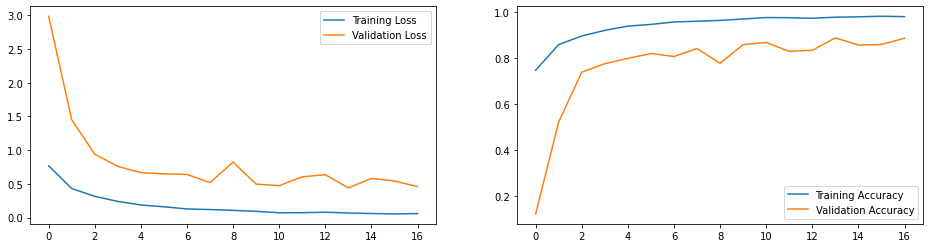

In [75]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [76]:
result_3 = {"Experiemnt": "Experiment 5.5: ResNet50 with one Hidden Layer DNN", "Test_Accuracy": accuracy,
            "loss": loss, "Train_Accuracy":train_accs[-1], "Train_Loss":train_losses[-1],
            "Val_Accuracy":val_accs[-1],
            "Val_Loss":val_losses[-1]}
results.append(result_3)

## Experiment 5.6: ResNet50 with DNN 2 hidden layers and drop put layers regularization

In [77]:
model1 = models.Sequential()
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(layers.UpSampling2D(size=(2,2)))
model1.add(tf.keras.applications.resnet.ResNet50(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet'))
model1.add(layers.Flatten())
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.BatchNormalization())
model1.add(layers.Dense(10, activation='softmax'))

In [78]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [79]:
history = model1.fit(x_train_norm
                    ,y_train_split
                    ,epochs=200
                    ,batch_size=100
                    ,validation_data=(x_valid_norm, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
                    tf.keras.callbacks.ModelCheckpoint('/mnt/Assignement2/models/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/200
450/450 [==============================] - 157s 349ms/step - loss: 1.1410 - accuracy: 0.6275 - val_loss: 2.7380 - val_accuracy: 0.1166
Epoch 2/200
450/450 [==============================] - 156s 346ms/step - loss: 0.6657 - accuracy: 0.7966 - val_loss: 1.1280 - val_accuracy: 0.6164
Epoch 3/200
450/450 [==============================] - 156s 346ms/step - loss: 0.5104 - accuracy: 0.8456 - val_loss: 0.9920 - val_accuracy: 0.7086
Epoch 4/200
450/450 [==============================] - 156s 346ms/step - loss: 0.4219 - accuracy: 0.8736 - val_loss: 0.6365 - val_accuracy: 0.7968
Epoch 5/200
450/450 [==============================] - 156s 346ms/step - loss: 0.3445 - accuracy: 0.8976 - val_loss: 0.6013 - val_accuracy: 0.8082
Epoch 6/200
450/450 [==============================] - 156s 346ms/step - loss: 0.2863 - accuracy: 0.9136 - val_loss: 0.6861 - val_accuracy: 0.7830
Epoch 7/200
450/450 [==============================] - 156s 346ms/step - loss: 0.2516 - accuracy: 0.9256 - val_loss: 0

In [80]:
history_dict = history.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)

In [81]:
train_losses = history.history["loss"]
train_accs = history.history["accuracy"]
val_losses = history.history["val_loss"]
val_accs = history.history["val_accuracy"]
epochs = len(train_losses)

In [82]:
loss, accuracy = model1.evaluate(x_test_norm, y_test)
print('test set accuracy: ', accuracy * 100, "%")

313/313 [==============================] - 12s 39ms/step - loss: 0.6383 - accuracy: 0.8209
test set accuracy:  82.0900022983551 %


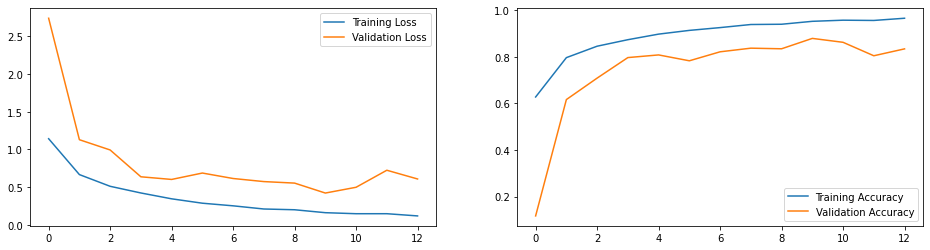

In [83]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([train_losses, train_accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [84]:
model1.save(str(accuracy)+'my_model.h5')

In [85]:
result_4 = {"Experiemnt": "Experiment 5.6: ResNet50 with DNN 2 hidden layers", "Test_Accuracy": accuracy,
            "loss": loss, "Train_Accuracy":train_accs[-1], "Train_Loss":train_losses[-1],
            "Val_Accuracy":val_accs[-1],
           "Val_Loss":val_losses[-1]}
results.append(result_4)

In [86]:
results_df = pd.DataFrame(results)

In [87]:
results_df.to_csv("exp5.5&5.6_output.csv", index=False)